# Evolutionary Computation Assignment 4

##### Solutions checked by solution checker

- Krzysztof Szala 144571
- Vadym Repetskyi 155610

# Problem description

#### The use of candidate moves in local search
- The goal of the task is to improve the time efficiency of the steepest local search with the use of
candidate moves using the neighborhood, which turned out to be the best in the previous
assignment,
- As candidate moves, we use moves that introduce at least one candidate edge to the solution. We
define the candidate edges by determining for each vertex 10 other “nearest” vertices (“nearest”
taking into account sum of the edge length and vertex cost). This parameter (10) can also be selected
experimentally to obtain the best results.
- Note that both in the case of intra-route moves (e.g. two-edges exchange) and inter-route moves
(nodes-exchange with one selected one not selected) we should ensure that at least one candidate
edge is introduced to the solution. In particular, it is not correct to exchange a selected node with
one of its nearest neighbors without adding to the solution at least one candidate edge.
- Note that there are in both cases two moves that introduce a given candidate edge.
- As starting solutions use random solutions.
- As baseline report also results of the steepest local search with random starting solutions without
these mechanisms.
- Computational experiment: Run each of the methods 200 times.

In [1]:
from utils import TspInstance, random_solution, local_search
import pandas as pd
import numpy as np

# Pseudocodes

## Candidate Moves

1. Generate Random Solution
2. Generate moves for each vertex with its 10 the closest vertices
    1. If move is improving solution -> that mean decreasing value of objective function, then add it to the set of improving moves
    2. If the closest move is within the cycle, then evaluate intra-move, if it's not, then evaluate inter-move
3. While there are improving moves
    1. Within all moves, choose move with the greatest improvement
    2. Apply the move to cycle
    3. Update list of all possible moves
4. Return Solution

In [2]:
def single_inter_move(tsp, solution, to_unselect, to_select):
    solution = solution.copy()
    insert_index = np.where(solution == to_unselect)[0][0]

    prev = solution[insert_index - 1]
    next = solution[(insert_index + 1) % len(solution)]

    cost_change = (
        tsp.node_costs[to_select]
        + tsp.distance_matrix[prev, to_select]
        + tsp.distance_matrix[to_select, next]
        - tsp.node_costs[to_unselect]
        - tsp.distance_matrix[prev, to_unselect]
        - tsp.distance_matrix[to_unselect, next]
    )
    
    return int(cost_change), to_unselect, to_select, "inter"

def apply_inter_move(solution, to_unselect, to_select):
    solution[np.where(solution == to_unselect)] = to_select
    return solution

In [3]:
def single_intra_move(tsp, solution, a, b):
    solution = solution.copy()
    index_a = np.where(solution == a)[0][0]
    index_b = np.where(solution == b)[0][0]
    
    if abs(index_a - index_b) == 1:
        return 0, a, b, "intra"

    a_prev = solution[index_a - 1]
    b_prev = solution[index_b - 1]
    if index_a - 1 < 0:
        a_prev = solution[len(solution) - 1]
    if index_b - 1 < 0:
        b_prev = solution[len(solution) - 1]

    a_next = solution[(index_a + 1) % len(solution)]
    b_next = solution[(index_b + 1) % len(solution)]

    cost_change = (
        tsp.distance_matrix[a, b]
        + tsp.distance_matrix[a_next, b_next]
        - tsp.distance_matrix[a, a_next]
        - tsp.distance_matrix[b, b_next]
    )

    return int(cost_change), a, b, "intra"

def apply_intra_move(solution, a, b):
    index_a = np.where(solution == a)[0][0]
    index_b = np.where(solution == b)[0][0]
    solution = solution.copy()
    if index_a < index_b:
        subsequence = solution[(index_a + 1):index_b+1][::-1]
        solution[(index_a + 1):index_b+1] = subsequence
    else:
        subsequence = solution[(index_b + 1):index_a+1][::-1]
        solution[(index_b + 1):index_a+1] = subsequence
    return solution

In [4]:
def find_best_node_best_moves(tsp, solution, node):
    candidate_buf_list = []
    
    closest_vertices = np.argsort(tsp.distance_matrix[node] + tsp.node_costs)
    closest_vertices = closest_vertices[closest_vertices != node][:10]

    node = int(node)
    for node_y in closest_vertices:
        node_y = int(node_y)
        if node_y in solution:
            cost_change, x, y, move_type = single_intra_move(tsp, solution, node, node_y)
        else:
            cost_change, x, y, move_type = single_inter_move(tsp, solution, node, node_y)

        if cost_change < 0:
            candidate_buf_list.append((cost_change, x, y, move_type))
            
    return candidate_buf_list

In [5]:
def update_candidate_list(tsp, solution, candidate_list, move):
    # find all moves that contain move[1] or move[2]
    if move[3] == "inter":
        affected_moves = [x for x in candidate_list if x[1] == move[1] or x[2] == move[1] or x[1] == move[2] or x[2] == move[2]]
    else:
        affected_moves = [x for x in candidate_list if x[1] == move[1] or x[2] == move[1] or 
                                                       x[1] == move[2] or x[2] == move[2] or 
                                                       x[1] == move[2] + 1 or x[2] == move[1] + 1 or
                                                       x[1] == move[1] + 1 or x[2] == move[2] + 1]
    # remove all affected moves from candidate list
    candidate_list = [x for x in candidate_list if x not in affected_moves]
    # for each node which was in some affected move, find new moves
    for node in set([x[1] for x in affected_moves] + [x[2] for x in affected_moves]):
        if node in solution:
            candidate_buf_list = find_best_node_best_moves(tsp, solution, node)
            if len(candidate_buf_list) > 0:
                # add only new moves
                candidate_list.extend([x for x in candidate_buf_list if x not in candidate_list])
    
    # remove duplicates
    candidate_list = list(set(candidate_list))
    
    return candidate_list

In [6]:
def candidate_list(tsp: TspInstance, start_node: int):
    
    # 1. Generate Random Solution
    solution = random_solution(tsp, start_node)
    # 2. Generate moves for each vertex with its 10 the closest vertices
    #     1. If move is improving solution -> that mean decreasing value of objective function, then add it to the set of improving moves
    #     2. If the closest move is within the cycle, then evaluate intra-move, if it's not, then evaluate inter-move
    
    # candidate_list, as a structure, which contains all possible moves, as: cost_change, node_x, node_y, move_type
    candidate_list = []
    
    for node_x in solution:
        candidate_buf_list = find_best_node_best_moves(tsp, solution, node_x)
        if len(candidate_buf_list) > 0:
            candidate_list.extend(candidate_buf_list)
                    
    # print("Initial candidate list: ", len(candidate_list))
    # 3. While there are improving moves
    count = 0
    costs = []
    last_cost = tsp.get_cost(solution)
    while len(candidate_list) > 0:
        # print(candidate_list)
        costs.append(tsp.get_cost(solution))
        #     1. Within all moves, choose move with the greatest improvement
        #     2. Apply the move to cycle
        best_move = min(candidate_list, key=lambda x: x[0])
        
        if best_move[0] == 0:
            print("Cost change is 0")
            break
        
        # print("Solution before: ", solution, "Cost before: ", tsp.get_cost(solution))
        solution = apply_intra_move(solution, best_move[1], best_move[2]) if best_move[3] == "intra" else apply_inter_move(solution, best_move[1], best_move[2])
        # print("Solution after: ", solution, "Cost after: ", tsp.get_cost(solution))
        # print("Cost change: ", best_move[0])
        #     3. Update list of all possible moves
        # print("Candidate list before: ", len(candidate_list))
        candidate_list = update_candidate_list(tsp, solution, candidate_list, best_move)
        # print("Candidate list after: ", len(candidate_list))
        count += 1

        # if count % 1000 == 0:
        #     print(f"Count: {count}")
        #     print(f"Best move cost: {tsp.get_cost(solution)}")
        #     print(len(candidate_list))
            
    # import matplotlib.pyplot as plt
    # plt.plot(costs)
    # plt.show()
            
    # 4. Return Solution
    return solution

# Experiments

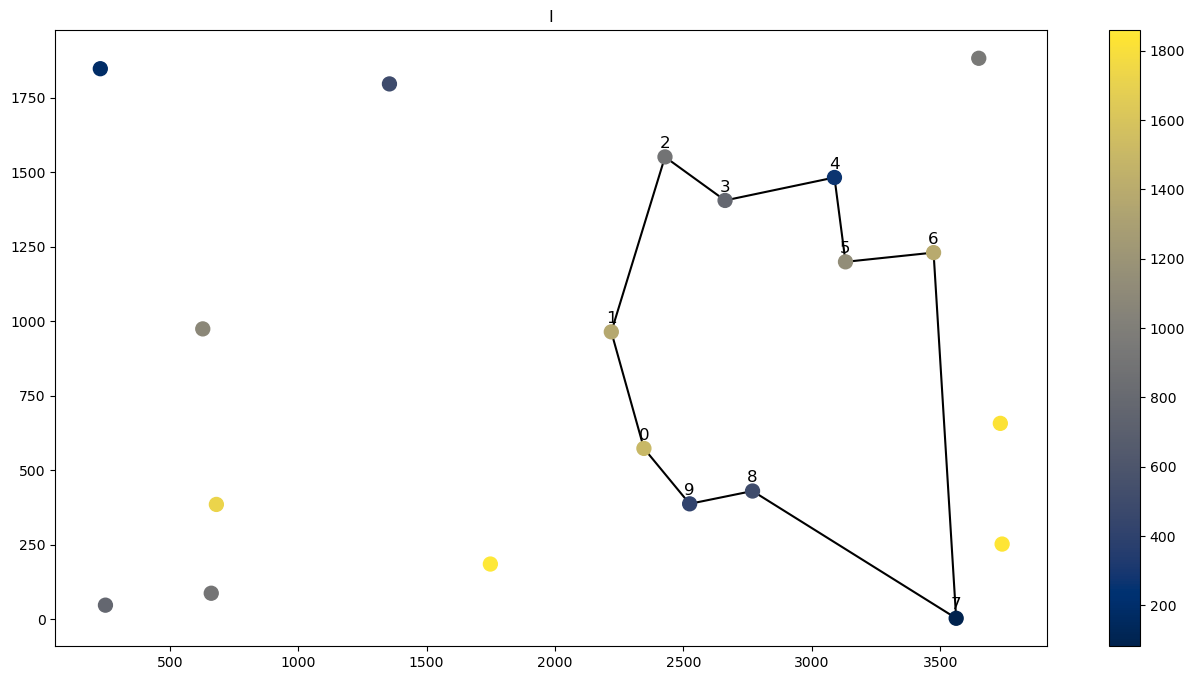

KeyboardInterrupt: 

In [7]:
columns = []
experiments = []

# for instance in (TspInstance("TSPA.csv"), TspInstance("TSPB.csv")):
for instance in (TspInstance("small_a.csv"), TspInstance("small_b.csv")):
    column = f"{instance.file_path[3]}"
    experiments.append(
        instance.run_experiments(
            candidate_list
        )
    )
    instance.plot(experiments[-1][-1], column)

# Conlusions